In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

### Question 2

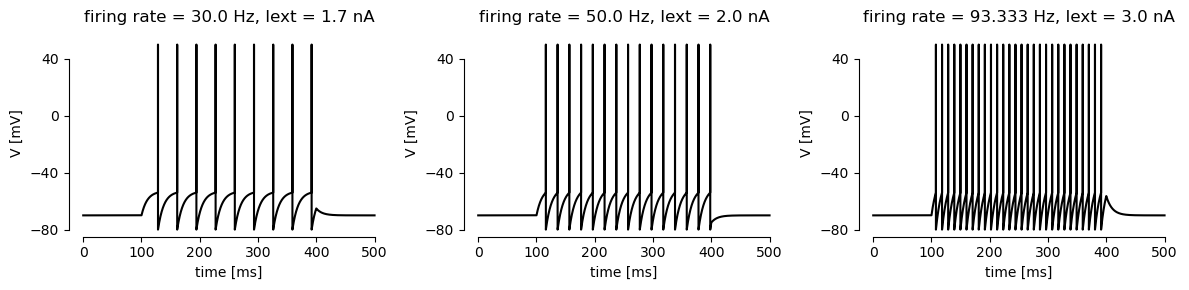

In [2]:
def integrate_and_fire(iext, timesteps, dt = 0.001, tau = 10, E = -70, R = 10, V_th = -54, V_reset = -80):
    """
    Implementation of an integrate and fire neuron. 

    E, V_th, V_reset in mV 
    tau in ms 
    R in M\Omega 
    iext in nA? 

    """

    time = np.arange(0, timesteps, dt) 
    Vs = []
    spikes = []
    Vs.append(E)

    current = np.zeros_like(time)
    start = int(100 / dt)
    end = int(400 / dt)
    current[start:end] = iext 
    
    for i in range(1, len(time)):
        dv = E + (R * current[i])
        V = dv + (Vs[i - 1] - dv) * np.exp(-dt / tau)
        Vs.append(V)

        if Vs[i] >= V_th:
            Vs[i-1] = 50
            Vs[i] = V_reset 
            spikes.append(1)   
    return time, Vs, spikes 

def theoretical_firing_rate(iext, tau_m = 10, R_m = 10, E = -70, V_reset = -80, V_th = -54):

    numerator = (R_m * iext) + E - V_reset
    denominator = (R_m * iext) + E - V_th 
    if denominator <= 0:
        return 0
    return (tau_m*(np.log(numerator/denominator)))**-1

timesteps = 500 
current_time = 0.3

fig = plt.figure(figsize = (12, 3))
ax = plt.subplot(1, 3, 1)
current = 1.7
t, V, spikes = integrate_and_fire(current, timesteps)
plt.plot(t, V, c = 'k')

plt.ylabel('V [mV]')
plt.ylim(-85, 60)
plt.yticks([-80, -40, 0, 40])
plt.xlabel('time [ms]')
plt.title(f'firing rate = {np.round(np.nansum(spikes) / (current_time), 3)} Hz, Iext = {current} nA')

ax = plt.subplot(1, 3, 2)
current = 2.0
t, V, spikes = integrate_and_fire(current, timesteps)
plt.plot(t, V, c = 'k')

plt.ylabel('V [mV]')
plt.ylim(-85, 60)
plt.yticks([-80, -40, 0, 40])
plt.xlabel('time [ms]')
plt.title(f'firing rate = {np.round(np.nansum(spikes) / (current_time), 3)} Hz, Iext = {current} nA')

ax = plt.subplot(1, 3, 3)
current = 3.0
t, V, spikes = integrate_and_fire(current, timesteps)
plt.plot(t, V, c = 'k')

plt.ylabel('V [mV]')
plt.ylim(-85, 60)
plt.yticks([-80, -40, 0, 40])
plt.xlabel('time [ms]')
plt.title(f'firing rate = {np.round(np.nansum(spikes) / (current_time), 3)} Hz, Iext = {current} nA')

sns.despine(trim = True)
plt.tight_layout()
plt.savefig('hw1_question2a.png')

In [3]:
current_steps = np.arange(0, 10.5, 0.5)
sim_rates, theoretical_rates = [], []
for current in current_steps:
    t, V, spikes = integrate_and_fire(current, timesteps)
    sim_rates.append(np.nansum(spikes) / (current_time))
    theoretical_rates.append(theoretical_firing_rate(current))

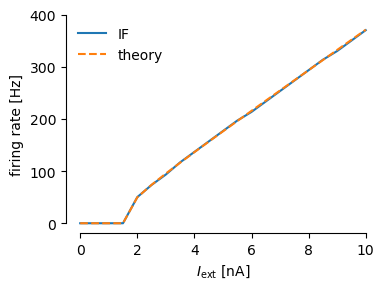

In [4]:
fig = plt.figure(figsize = (4, 3))
plt.plot(current_steps, sim_rates, label = 'IF')
plt.plot(current_steps, np.array(theoretical_rates)*1000, label = 'theory', linestyle = 'dashed')

plt.xlabel(r'$I_{\text{ext}}$ [nA]')
plt.ylabel('firing rate [Hz]')
plt.yticks([0, 100, 200, 300, 400])
plt.legend(frameon = False)
sns.despine(trim = True)
plt.tight_layout()
plt.savefig('hw1_question2b.png')

### Question 3 -- Hodgkin & Huxley

In [5]:
def alpha_n(V):
    return (0.01 * (V + 55)) / (1 - (np.exp(-0.1 * (V + 55))))

def beta_n(V):
    return 0.125 * np.exp(-0.0125 * (V + 65)) 

def alpha_m(V):
    return (0.1 * (V + 40)) / (1 - np.exp(-0.1 * (V + 40)))

def beta_m(V):
    return 4 * np.exp(-0.0556 * (V + 65))

def alpha_h(V):
    return 0.07 * np.exp(-0.05 * (V + 65))

def beta_h(V):
    return 1 / (1 + np.exp(-0.1 * (V + 35)))

def hodgkin_huxley(iext, T = 100, V0 = -65, m0 = 0.0529, h0 = 0.5961, n0 = 0.3177, cm = 0.01, bar_gl = 0.003, bar_gna = 1.2, bar_gk = 0.36, E_l = -54.387, E_Na = 50, E_K = -77, dt = 0.01, iext_A = 1e-3):

    # Store the output 
    Vs, ms, ns, hs, spikes = [], [], [], [], []

    # Initialize variables 
    V, m, n, h = V0, m0, n0, h0 

    # Time vector 
    t = np.arange(0, T, dt) 

    if np.isscalar(iext):
        iext = np.ones(shape = t.shape[0]) * iext
    
    for i, _ in enumerate(t):
        # Compute currents 
        im = (bar_gl * (V - E_l)) + (bar_gna * m**3 * h * (V - E_Na)) + (bar_gk * n**4 * (V - E_K))
        # Compute the updates 
        dv = ((-im + (iext[i] * iext_A)) / cm) * dt
        dn = (((1 - n) * alpha_n(V)) - (n * beta_n(V))) * dt
        dm = (((1 - m) * alpha_m(V)) - (m * beta_m(V))) * dt 
        dh = (((1 - h) * alpha_h(V)) - (h * beta_h(V))) * dt 

        # Update variables 
        V += dv 
        m += dm 
        n += dn 
        h += dh 

        if len(Vs) > 1 and Vs[-1] < 0 and V >= 0:
            spikes.append(1)
        
        Vs.append(V)
        ms.append(m)
        ns.append(n)
        hs.append(h)

    return Vs, ms, ns, hs, t, spikes

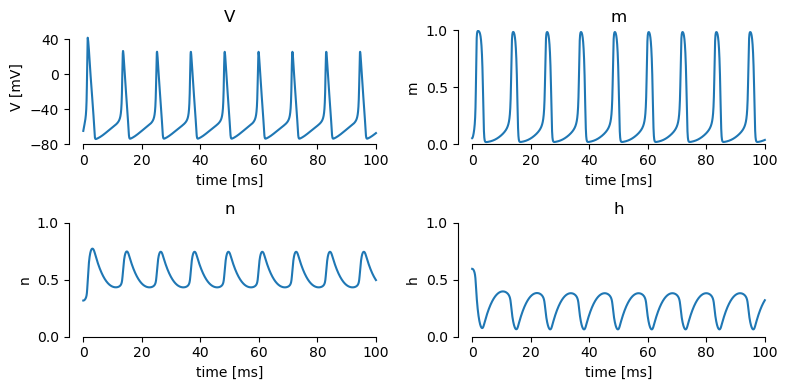

In [6]:
V, m, n, h, t, spikes = hodgkin_huxley(200)

fig = plt.figure(figsize = (8, 4))

ax = plt.subplot(2, 2, 1)
plt.plot(t, V)
plt.ylim(-80, 50)
plt.yticks([-80, -40, 0, 40])
plt.ylabel('V [mV]')
plt.xlabel('time [ms]')
plt.title('V')

ax = plt.subplot(2, 2, 2)
plt.plot(t, m)
plt.title('m')
plt.ylabel('m')
plt.ylim(0, 1)
plt.yticks([0, 0.5, 1.0])
plt.xlabel('time [ms]')

ax = plt.subplot(2, 2, 3)
plt.plot(t, n)
plt.title('n')
plt.ylabel('n')
plt.ylim(0, 1)
plt.yticks([0, 0.5, 1.0])
plt.xlabel('time [ms]')

ax = plt.subplot(2, 2, 4)
plt.plot(t, h)
plt.title('h')
plt.ylim(0, 1)
plt.ylabel('h')
plt.yticks([0, 0.5, 1.0])
plt.xlabel('time [ms]')

sns.despine(trim = True)
plt.tight_layout()
plt.savefig('hw1_figure3a.png')

In [7]:
iext = np.arange(0, 525, 25)
rates = []

for i, current in enumerate(iext):
    V, _, _, _, _, spikes = hodgkin_huxley(current)
    rates.append(np.nansum(spikes) / 0.1)

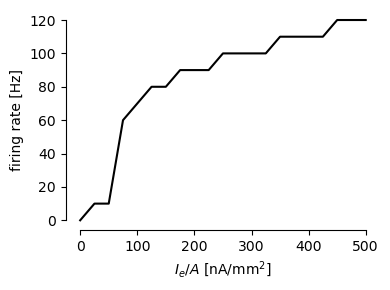

In [8]:
figure = plt.figure(figsize = (4, 3))
plt.plot(iext, rates, color = 'k')
plt.ylabel('firing rate [Hz]')
plt.xlabel(r'$I_e/A$ [$\text{nA/mm}^2$]')

sns.despine(trim = True)
plt.tight_layout()
plt.savefig('hw1_figure3b.png')

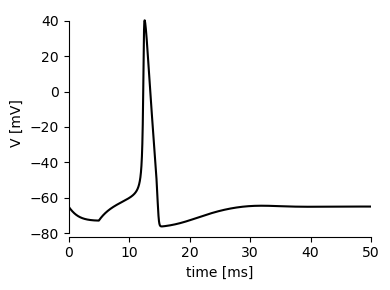

In [9]:
dt = 0.01 
timesteps = np.arange(0, 100, dt)
current = np.zeros(shape = (timesteps.shape[0]))
current[:int(5/dt)] = -50 


V, _, _, _, t, _ = hodgkin_huxley(current)

fig = plt.figure(figsize = (4, 3))
plt.plot(t, V, c = 'k')
plt.xlabel('time [ms]')
plt.xlim(0, 50)
plt.ylabel('V [mV]')

sns.despine(trim = True)
plt.tight_layout()
plt.savefig('hw1_figure3c.png')